# SPGR

In [1]:
import version_control

Last run on cashlab03-deb at 2015-01-30 12:32:40.368621

Phypno Version: 25a4d9bd98a21493421fa0eea826edbc73b68ea3

Cython==0.21.2, Jinja2==2.7.3, Markdown==2.5.2, MarkupSafe==0.23, Pillow==2.7.0, PyOpenGL==3.1.0, Pygments==2.0.2, Sphinx==1.2.3, beautifulsoup4==4.3.2, certifi==14.05.14, coverage==3.7.1, decorator==3.4.0, docutils==0.12, easydev==0.8.2, ipython==2.3.1, matplotlib==1.4.2, memory-profiler==0.32, networkx==1.9.1, nibabel==2.0.0, nitime==0.5, nose==1.3.4, numpy==1.9.1, numpydoc==0.5, ordereddict==1.1, pandas==0.15.2, pep8==1.5.7, psutil==2.2.0, pycurl==7.19.5.1, pyflakes==0.8.1, pyparsing==2.0.3, pyqtgraph==0.9.10, python-dateutil==2.4.0, python-igraph==0.7, pytz==2014.10, pyzmq==14.5.0, rope-py3k==0.9.4-1, rpy2==2.5.4, scikit-learn==0.15.2, scipy==0.15.1, six==1.9.0, sphinxcontrib-napoleon==0.2.9, spyder==2.3.2, tornado==4.0.2, visvis==1.9.1, xmltodict==0.9.1, 


## Spindle Properties: Statistics

### Parameters

In [2]:
hemi_subj = {'EM09': 'rh', 
             'MG17': 'rh',
             'MG33': 'lh',
             'MG37': 'lh',
             'MG61': 'lh',
             'MG63': 'rh',
             }
all_subj = sorted(hemi_subj.keys())

In [3]:
options = {'reref': 'avg',
           'resample_freq': 256,
           'hp_filter': 0.5,
           'lp_filter': 50,
           }
chan_type = ('grid', )

In [4]:
spindles_options = {'method': 'Nir2011', 
                    'frequency': (9, 16), 
                    'duration':(0.5, 2),
                    }
spindles_options.update(options)

In [5]:
STD = 10
THRESHOLD = 20

### Get Spindles

In [6]:
from os import makedirs
from os.path import join
from phypno.attr import Freesurfer
from phypno.attr.chan import assign_region_to_channels
from phypno.source import Linear, Morph
from spgr.detect_spindles import get_spindles
from spgr.read_data import FS_PATH, GROUP_DIR, REC_DIR, get_chan_used_in_analysis, get_data

In [7]:
OUTPUT_DIR = join(GROUP_DIR, 'property_statistics')
makedirs(OUTPUT_DIR, exist_ok=True)

In [8]:
all_chan = []

for subj in all_subj:
    fs = Freesurfer(join(REC_DIR, subj, FS_PATH))
    chan = get_chan_used_in_analysis(subj, 'sleep', chan_type, **options)
    chan = assign_region_to_channels(chan, fs, exclude_regions=('Unknown', ))
    all_chan.append(chan)

INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:EM09 analysis chan 69, with location 69
/home/gio/tools/phypno/phypno/attr/anat.py:83: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  pos[2] + neighb[p, 2]]
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG17 analysis chan 93, with location 93
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG33 analysis chan 64, with location 64
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG37 analysis chan 78, with location 78
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG61 analysis chan 93, with location 93
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG63 analysis chan 93, with location 93


In [9]:
all_count = []
all_freq = []

for subj in all_subj:
    data = get_data(subj, 'sleep', chan_type, **options)
    spindles = get_spindles(subj, **spindles_options)
    dat_count = spindles.to_data('count')
    dat_count.data[0] = dat_count.data[0] / data.number_of('trial') * (data.axis['time'][0][-1] - data.axis['time'][0][0])
    all_count.append(dat_count)
    dat_freq = spindles.to_data('peak_freq')
    all_freq.append(dat_freq)

INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj EM09, reading data: EM09_sleep_grid_hp005_lp500_avg_rs256.pkl
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj MG17, reading data: MG17_sleep_grid_hp005_lp500_avg_rs256.pkl
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj MG33, reading data: MG33_sleep_grid_hp005_lp500_avg_rs256.pkl
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj MG37, reading data: MG37_sleep_grid_hp005_lp500_avg_rs256.pkl
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj MG61, reading data: MG61_sleep_grid_hp005_lp500_avg_rs256.pkl
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj MG63, reading data: MG63_sleep_grid_hp005_lp500_avg_rs256.pkl


In [10]:
fs = Freesurfer('/opt/freesurfer/subjects/fsaverage')
surf = fs.read_surf('rh')
label = fs.read_label('rh')

### Spindle Density

To assess statistically if there were differences in the spindle parameters (spindle density and peak in the power spectrum) between brain regions, we applied $[LMEM] to the values measured at each electrode.
First, we quantified the number of spindles per minutes at each electrode.
Based on the brain reconstruction, each electrode was assigned a label indicating to which region the electrode belonged to, from the gyral-based cortical parcellation that ships with FreeSurfer [@Desikan2006].

In [11]:
from pandas import DataFrame

In [206]:
df_raw = []

for subj, one_dat, one_channel in zip(all_subj, all_count, all_chan):
    for one_chan in one_dat.axis['chan'][0]:
        region = one_channel.return_attr('region', (one_chan, ))[0]
        value = one_dat(trial=0, chan=one_chan)
        
        if region[:3] == 'ctx':
            region = region[7:]
    
            df_raw.append({'subj': subj,
                           'region': region,
                           'elec': one_chan,
                           'value': value})

In [211]:
df = DataFrame(df_raw)

In [14]:
%load_ext rmagic

In [298]:
%%R
library(lme4)
library(multcomp)
options(contrasts=c('contr.treatment', 'contr.poly'))
options(scipen=999)

In [214]:
%%R -i df -o tstat -o regions -o pvalues
options(contrasts=c('contr.sum', 'contr.poly'))
df$value <-  as.numeric(levels(df$value))[df$value]

n_regions <- length(levels(df$region))
x <- diag(n_regions) 
x[x==0] <- -1/(n_regions - 1)
row.names(x) <- levels(df$region)

intercept <- rep( 1 / n_regions, n_regions)
x <- rbind(x, intercept)

lm1 <- lmer(value ~ 0 + region + (1|subj), df)

comps <- glht(lm1, x)
s <- summary(comps,  test = adjusted("fdr"))
# s <- summary(comps)
print(s)

tstat <- s$test$coefficients
pvalues <- s$test$pvalues
regions <- levels(df$region)


	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = value ~ 0 + region + (1 | subj), data = df)

Linear Hypotheses:
                          Estimate Std. Error z value Pr(>|z|)    
bankssts == 0               1.9768     3.7775   0.523  0.69563    
caudalmiddlefrontal == 0    8.0639     2.4385   3.307  0.00415 ** 
fusiform == 0              -5.1064     4.1986  -1.216  0.35621    
inferiorparietal == 0      -2.0519     1.6972  -1.209  0.35621    
inferiortemporal == 0      -5.8362     1.6234  -3.595  0.00178 ** 
insula == 0                -1.0440     5.8993  -0.177  0.90046    
lateraloccipital == 0       3.2318     3.0367   1.064  0.39491    
lateralorbitofrontal == 0   0.1269     2.6413   0.048  0.96167    
medialorbitofrontal == 0   -3.4357     4.2571  -0.807  0.51289    
middletemporal == 0        -3.8859     1.2265  -3.168  0.00562 ** 
parsopercularis == 0        4.4483     2.1228   2.095  0.07949 .  
parsorbitalis == 0          5.9896     2.8345   2.113  0.07

An $[LMEM], which takes into account the different number of electrodes per brain region and the variability across subjects, was computed to test the hypothesis that the number of spindles is different between brain regions.
The estimated average value for the number of spindles per minute was 15.45 (Fig. +[spgr_statistics]A).
Some regions had a significantly higher spindle density (rostral middle frontal region had 23.56 spindles / min, fdr-corrected p-value < 0.001; caudal middle frontal region had 23.51 spindles / min, fdr-corrected p-value = 0.004; pars triangularis had 23.34 spindles / min, fdr-corrected p-value = 0.001) than the estimated average value.
Regions in temporal cortex, on the other hand, had significant lower spindle density (superior temporal cortex had 11.4 spindles / min, fdr-corrected p-value = 0.01; middle temporal cortex had 11.57 spindles / min, fdr-corrected p-value = 0.006; inferior temporal cortex had 9.61 spindles / min, fdr-corrected p-value = 0.002).

In [222]:
intercept = tstat[-1]
tstat = tstat[:-1]
pvalues = pvalues[:-1]

In [223]:
alpha = 0.05
values = tstat + intercept
# values[pvalues >= alpha] = NaN

In [227]:
from numpy import array, zeros, NaN
from visvis import screenshot
from phypno.viz import Viz3

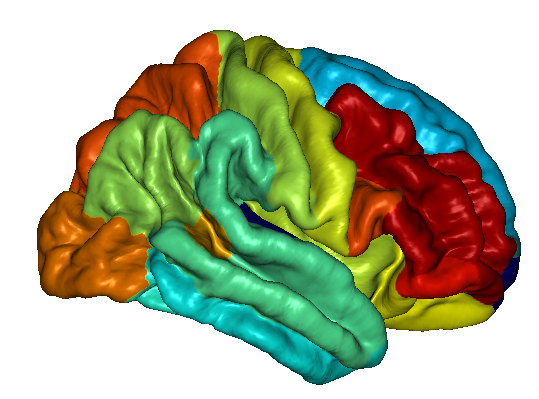

In [229]:
val = zeros(label[0].shape)
val.fill(NaN)

for one_region, one_v in zip(regions, values):
    val[array(label[0]) == label[2].index(one_region)] = one_v

v = Viz3()
v.add_surf(surf, values=val, limits_c=(0, 25))
v._canvas.DrawNow()
screenshot(join(OUTPUT_DIR, 'density.png'), v._viewbox, sf=2)
v

### Frequency

In [230]:
df_raw = []

for subj, one_dat, one_channel in zip(all_subj, all_freq, all_chan):
    for one_chan in one_dat.axis['chan'][0]:
        region = one_channel.return_attr('region', (one_chan, ))[0]
        value = one_dat(trial=0, chan=one_chan)
        
        if region[:3] == 'ctx':
            region = region[7:]
    
            df_raw.append({'subj': subj,
                           'region': region,
                           'elec': one_chan,
                           'value': value})

In [231]:
df = DataFrame(df_raw)

In [246]:
%%R -i df -o tstat -o regions -o pvalues
options(contrasts=c('contr.sum', 'contr.poly'))
df$value <-  as.numeric(levels(df$value))[df$value]

n_regions <- length(levels(df$region))
x <- diag(n_regions) 
x[x==0] <- -1/(n_regions - 1)
row.names(x) <- levels(df$region)

intercept <- rep( 1 / n_regions, n_regions)
x <- rbind(x, intercept)

lm1 <- lmer(value ~ 0 + region + (1|subj), df)

comps <- glht(lm1, x)
s <- summary(comps,  test = adjusted("fdr"))
print(s)

tstat <- s$test$coefficients
pvalues <- s$test$pvalues
regions <- levels(df$region)


	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = value ~ 0 + region + (1 | subj), data = df)

Linear Hypotheses:
                          Estimate Std. Error z value Pr(>|z|)    
bankssts == 0             -1.21445    0.30428  -3.991 0.000241 ***
caudalmiddlefrontal == 0   0.15110    0.19639   0.769 0.607289    
fusiform == 0             -0.78511    0.33824  -2.321 0.049568 *  
inferiorparietal == 0     -0.39653    0.13666  -2.902 0.010211 *  
inferiortemporal == 0     -0.61727    0.13070  -4.723 1.02e-05 ***
insula == 0                0.21582    0.47519   0.454 0.719384    
lateraloccipital == 0     -0.30838    0.24459  -1.261 0.325883    
lateralorbitofrontal == 0 -0.22207    0.21270  -1.044 0.434799    
medialorbitofrontal == 0  -0.55802    0.34283  -1.628 0.175316    
middletemporal == 0       -0.30077    0.09870  -3.047 0.007253 ** 
parsopercularis == 0       0.07666    0.17103   0.448 0.719384    
parsorbitalis == 0        -0.06549    0.22836  -0.287 0.811

In [251]:
11.79062 + -1.21445

10.576170000000001

We then calculated an $[LMEM] to estimate the peak in the power spectrum over multiple brain regions.
The estimated average value for the spindle frequency was 11.79 Hz (Fig. +[spgr_statistics]B).
Some regions had a significantly higher spindle frequency (superior parietal region had 13.23 Hz, fdr-corrected p-value < 0.001; precentral region had 12.67 Hz, fdr-corrected p-value < 0.001; postcentral region had 12.73 Hz, fdr-corrected p-value < 0.001) than the estimated average value.
The inferior and middle temporal cortices, on the other hand, had significant lower spindle frequency (middle temporal cortex had 11.49 Hz, fdr-corrected p-value = 0.007; inferior temporal cortex had 11.18 Hz, fdr-corrected p-value < 0.001; the bank of the superior temporal sulcus had 10.58 Hz, fdr-corrected p-value < 0.001).

In [242]:
intercept = tstat[-1]
tstat = tstat[:-1]
pvalues = pvalues[:-1]

In [243]:
alpha = 0.05
values = tstat + intercept
# values[pvalues >= alpha] = NaN

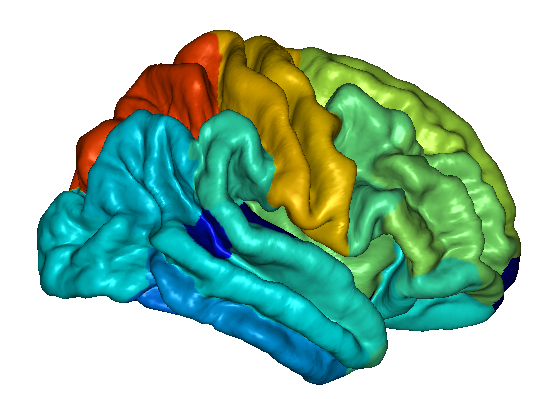

In [244]:
val = zeros(label[0].shape)
val.fill(NaN)

for one_region, one_v in zip(regions, values):
    val[array(label[0]) == label[2].index(one_region)] = one_v

v = Viz3()
v.add_surf(surf, values=val, limits_c=(10, 14))
v._canvas.DrawNow()
screenshot(join(OUTPUT_DIR, 'frequency.png'), v._viewbox, sf=2)
v

### Frequency Direction (subset of regions)

In addition, we investigated the question of whether the peak in the power spectrum for the spindle activity varies spatially over the cortex. 
We hypothesized that spindle frequency increases while moving towards the posterior regions.
Therefore, we tested whether the spindle frequency at each electrodes was dependent on the x, y, z electrode positions, codified as $[RAS] coordinates.

In [171]:
good_regions = ['caudalmiddlefrontal',
                'insula',
                'lateralorbitofrontal',
                'medialorbitofrontal',
                'parsopercularis',
                'parsorbitalis',
                'parstriangularis',
                'postcentral',
                'precentral',
                'rostralmiddlefrontal',
                'superiorfrontal',
                'superiorparietal',
                'supramarginal',
                ]

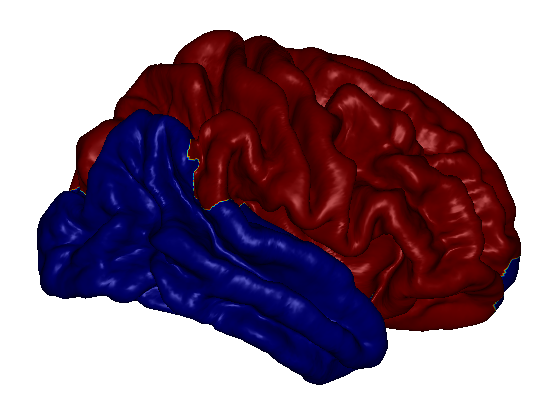

In [262]:
val = zeros(label[0].shape)
for one_region in label[2]:
    if one_region in good_regions:
        val[array(label[0]) == label[2].index(one_region)] = 1

v = Viz3()
v.add_surf(surf, values=val, limits_c=(0, 1))
v._canvas.DrawNow()
screenshot(join(OUTPUT_DIR, 'freq_selectedregions.png'), v._viewbox, sf=2)
v

We limited our analysis to only frontal and parietal regions, as we expected a linear trend in terms of spindle frequency over these regions (Fig. +[spgr_stats_linear]A).

In [267]:
df_raw = []

for subj, one_dat, one_channel in zip(all_subj, all_freq, all_chan):
    for one_chan in one_dat.axis['chan'][0]:
        region = one_channel.return_attr('region', (one_chan, ))[0]
        x = one_channel.return_xyz((one_chan, ))[0, 0]
        y = one_channel.return_xyz((one_chan, ))[0, 1]
        z = one_channel.return_xyz((one_chan, ))[0, 2]
        value = one_dat(trial=0, chan=one_chan)
        
        if region[:3] == 'ctx' and region[7:] in good_regions:
    
            df_raw.append({'subj': subj,
                           'xpos': x,
                           'ypos': y,
                           'zpos': z,
                           'elec': one_chan,
                           'value': value})

In [268]:
df = DataFrame(df_raw)

In [299]:
%%R -i df -o tstat -o regions -o pvalues
options(contrasts=c('contr.sum', 'contr.poly'))
df$value <-  as.numeric(levels(df$value))[df$value]

lm1 <- lmer(value ~ 1 + xpos * ypos * zpos + (1|subj), df)
print(summary(lm1))

coefs <- data.frame(coef(summary(lm1)))
coefs$p.value <- 2 * (1 - pnorm(abs(coefs$t.value)))
coefs

Linear mixed model fit by REML ['lmerMod']
Formula: value ~ 1 + xpos * ypos * zpos + (1 | subj)
   Data: df

REML criterion at convergence: 673.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6884 -0.5244 -0.0561  0.4604  3.2856 

Random effects:
 Groups   Name        Variance Std.Dev.
 subj     (Intercept) 0.4420   0.6648  
 Residual             0.4995   0.7067  
Number of obs: 257, groups:  subj, 6

Fixed effects:
                    Estimate    Std. Error t value
(Intercept)    11.5234174029  0.2970384610   38.79
xpos           -0.0005369189  0.0034618050   -0.16
ypos            0.0110067237  0.0033618127    3.27
zpos            0.0220548735  0.0031550582    6.99
xpos:ypos      -0.0001213701  0.0000758976   -1.60
xpos:zpos       0.0000522103  0.0000718939    0.73
ypos:zpos      -0.0002674097  0.0000803447   -3.33
xpos:ypos:zpos  0.0000004973  0.0000020850    0.24

Correlation of Fixed Effects:
            (Intr) xpos   ypos   zpos   xps:yp xps:zp yps:zp
xpos       

We observed that spindle frequency increased linearly as electrodes were positioned over more posterior regions (by 0.011 Hz/mm based on y-value in $[RAS] coordinate system, p-value = 0.001) and over more superior regions (by 0.022 Hz/mm based on z-value, p-value < 0.001).
However, the position of the left-right axis was not significant (p-value = 0.88).
In addition, the interaction between the y and z axises was also significant (estimated = 0.0003 Hz / mm^2^, p-value < 0.001).

In [316]:
%%R -i df -o tstat -o regions -o pvalues
options(contrasts=c('contr.sum', 'contr.poly'))
df$value <-  as.numeric(levels(df$value))[df$value]

lm1 <- lmer(value ~ 1 + ypos * zpos + (1|subj), df)
print(summary(lm1))

Linear mixed model fit by REML ['lmerMod']
Formula: value ~ 1 + ypos * zpos + (1 | subj)
   Data: df

REML criterion at convergence: 615

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7988 -0.6067 -0.0835  0.5093  3.3547 

Random effects:
 Groups   Name        Variance Std.Dev.
 subj     (Intercept) 0.4282   0.6544  
 Residual             0.5154   0.7179  
Number of obs: 257, groups:  subj, 6

Fixed effects:
               Estimate  Std. Error t value
(Intercept) 11.47166771  0.29169353   39.33
ypos         0.00863623  0.00323763    2.67
zpos         0.02260621  0.00301843    7.49
ypos:zpos   -0.00021889  0.00007653   -2.86

Correlation of Fixed Effects:
          (Intr) ypos   zpos  
ypos      -0.226              
zpos      -0.360  0.491       
ypos:zpos  0.171 -0.834 -0.307


In [317]:
%%R
print(min(df$ypos))
print(max(df$ypos))

print(min(df$zpos))
print(max(df$zpos))

[1] -69.57
[1] 70.82
[1] -8.888
[1] 76.52


In [318]:
%%R -o newdat
newdat <- expand.grid(ypos=seq(-70, 70), zpos=seq(-8, 76), value=0)

mm <- model.matrix(terms(lm1), newdat)
newdat$value <- mm %*% fixef(lm1)

In [319]:
A = newdat[2]
A.shape = 85, 141

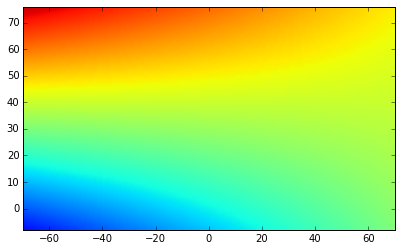

In [321]:
%matplotlib inline
from matplotlib.pyplot import savefig, imshow
imshow(squeeze(A), origin='lower', extent=(-70, 70, -8, 76), vmin=10, vmax=14) 
savefig(join(OUTPUT_DIR, 'freq_linearchanges.png'))

Based on these estimates, we calculated the expected spindle frequency in function of the anterior-posterior and superior-inferior recording position (Fig. +[spgr_stats_linear]B).